### 1-D Richards equation solver code
- formulation based on a backward Euler implementation of the mixed theta-head formulation of the 1-D Richards equation, with a modified Picard iteration finite differencing solution scheme, with a modified Picard iteration finite differencing solution scheme.

- The soil water retention parameterization used is that of van Genuchten 
 [1980], and this code requires the corresponding MATLAB function        
 vanGenuchten.m.  
 
 - coordinate axis:  positive  downward
         z[0] = 0  (top)
         z[-1] = 100  (bottom)

In [297]:
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
import time

In [298]:
%matplotlib inline

In [299]:
def vanGenuchten(h,phi) :
    alpha   = phi[0]
    theta_S = phi[1]
    theta_R = phi[2]
    n       = phi[3]
    m       = phi[4]
    Ksat    = phi[5] 
    # Compute the volumetric moisture content
    theta = (theta_S - theta_R)/(1 + (alpha*abs(h))**n)**m + theta_R; 
    ## Compute the effective saturation
    Se = ((theta - theta_R)/(theta_S - theta_R)); 
    # Compute the hydraulic conductivity
    K = Ksat*Se**(1./2)*(1 - (1 - Se**(1./m))**m)**2; 
    # Compute the specific moisture storage
    C =  -alpha*n*np.sign(h)*(1./n - 1)*(alpha*abs(h))**(n - 1)*(theta_R - 
         theta_S)*((alpha*abs(h))**n + 1)**(1/n - 2);
    try:
        for i in range(len(h)):
            if h[i] > 0:
                K[i] = Ksat
                C[i] = 0.
                theta[i] = theta_S
    except TypeError:
        if h > 0:
            K = Ksat
            C = 0.
            theta = theta_S
    return [C,K,theta]

In [300]:
# Define van Genuchten parameters
alpha   = 0.0335
theta_S = 0.368;
theta_R = 0.102;
lambdA  = 0.25
n       = lambdA + 1
m       = lambdA/n
Ksat    = 0.09

# Store van Genuchten parameters in array
phi = np.zeros(6)
phi[0] = alpha
phi[1] = theta_S
phi[2] = theta_R
phi[3] = n
phi[4] = m
phi[5] = Ksat

In [312]:
# set grid and initial conditions
dz = 1.; # [cm]
zmin = 0.; # [cm]
zmax = 100.; # [cm]
z = np.arange(zmin, zmax+1, dz)
nz   =  z.shape[0]

# Define boundary conditions at top and bottom
# hinit = np.arange(nz)*-5
hinit = -1000*np.ones(nz)
hinit[0] = 30

htop = hinit[0]
hbottom = hinit[-1]

In [313]:
# Define matrices that we'll need in solution
BottomBoundCon = 1  # 0 = constant head, 1 = free drainage
DeltaPlus  = np.diag(-np.ones(nz)) + np.diag(np.ones(nz-1), 1)
DeltaPlus[0,:] = 0
DeltaPlus[nz-1,:] = 0

DeltaMinus = np.diag(np.ones(nz)) + np.diag(-np.ones(nz-1),-1);
DeltaMinus[0,:] = 0
DeltaMinus[nz-1,:] = 0

MPlus = np.diag(np.ones(nz))+np.diag(np.ones(nz-1),1)
MPlus[0,0] = 2
MPlus[0,1:nz-1] = 0
MPlus[nz-1,nz-1] = 2
MPlus[nz-1,:nz-1] = 0  # not needed

MMinus = np.diag(np.ones(nz)) + np.diag(np.ones(nz-1),-1)
MMinus[0,0] = 2
MMinus[0,1:nz-1] = 0  # not needed
MMinus[nz-1,nz-1] = 2
MMinus[nz-1,:nz-1] = 0 

In [316]:
# Define time variables
stop_tol = 1  # Stopping tolerance [cm]
dt = .1 # [s]
tmin = 0. # [s]
nt = 100
tmax = dt*(nt - 1.) # [s]

t = np.arange(tmin, tmax+1, dt)[:nt]  #(tmin:dt:tmax);

# Define a storage container to store the pressure heads and soil moistures
[Ctop,Ktop,thetatop] = vanGenuchten(htop,phi)
[Cbottom,Kbottom,thetabottom] = vanGenuchten(hbottom,phi)
[Cinit,Kinit,thetainit] = vanGenuchten(hinit,phi) 
H = np.zeros([nz,nt])
K = np.zeros([nz,nt])
C = np.zeros([nz,nt])
H[:,0] = hinit
K[:, 0] = Kinit
C[:, 0] = Cinit

THETA = np.zeros([nz,nt])
THETA[:,0] = thetainit
ktop = np.zeros([ nt])
kbot = np.zeros([ nt])
error = np.zeros([nt])
err_sum = np.zeros([nt])
err_c = np.zeros([nt])
err_bot = np.zeros([nt])
err_top= np.zeros([nt])

KeyboardInterrupt: 

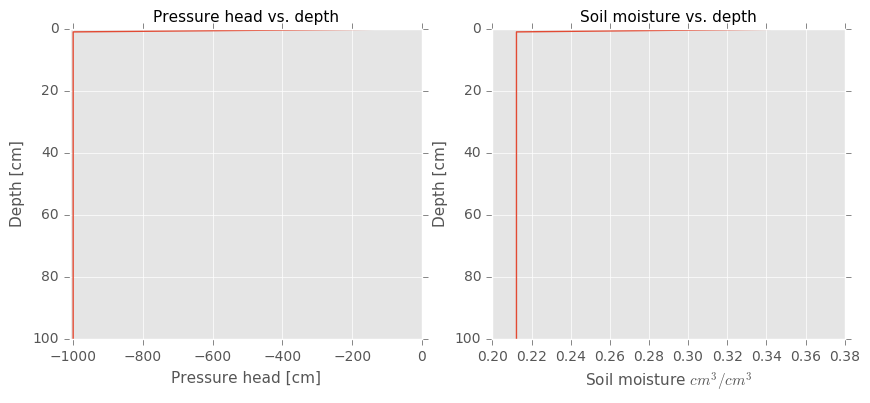

In [317]:
# Figures
plt.figure(1, figsize = (10,4)); 
ax = plt.subplot(121)
plt.plot(hinit,z);
plt.xlabel('Pressure head [cm]',fontsize=  11)
plt.ylabel('Depth [cm]',fontsize=  11)
plt.xlim( -1010, 0)
plt.gca().invert_yaxis()
plt.title('Pressure head vs. depth', fontsize=  11)
ax = plt.subplot(122)
plt.plot(thetainit,z)
plt.xlabel('Soil moisture $cm^3/cm^3$',fontsize=  11)
plt.ylabel('Depth [cm]',fontsize=  11)
plt.gca().invert_yaxis()
plt.title('Soil moisture vs. depth',fontsize=  11)

start_time = time.time()
iterations = np.zeros([nt-1,1]);  # Define array for iteration counter

for i in range(1, nt):   # Initialize the Picard iteration solver
    hnp1m =  H[:,i-1]  
    #Enter the iteration step
    thetan = THETA[:,i-1]   
    #Define a dummy stopping variable
    stop_flag = 0
    # Define an iteration counter
    niter = 0
    while(stop_flag==0): # Get C,K,theta
        [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1m,phi)
        Cdiag = np.diag(cnp1m) # Compute the individual elements of the A matrix for LHS
        kbarplus = (1/2.)*MPlus.dot(knp1m)
        Kbarplus = np.diag(kbarplus)
        kbarminus = (1/2.)*MMinus.dot(knp1m)
        Kbarminus = np.diag(kbarminus)
        A = (1./dt)*Cdiag - 1./((dz)**2)*(Kbarplus.dot(DeltaPlus) - 
                                          Kbarminus.dot(DeltaMinus)) 
        #  Compute the residual of MPFD (RHS)
        R_MPFD = (1./(dz**2))*(Kbarplus.dot(DeltaPlus).dot(hnp1m) - \
                               Kbarminus.dot(DeltaMinus).dot(hnp1m)) + \
            (1./dz)*(kbarplus - kbarminus) - (1./dt)*(thetanp1m - thetan); 
        # Compute deltam for iteration level m+1

        deltam = np.linalg.pinv(A).dot(R_MPFD)
        # Increment iteration counter and display number of iterations
        niter = niter + 1;
        if max(abs(deltam[1:(nz-1)]))<stop_tol:
            stop_flag = 1
            hnp1mp1 = hnp1m + deltam # Force boundary conditions       
            hnp1mp1[0] = htop;
            if BottomBoundCon==0:
                hnp1mp1[nz-1] = hbottom;
            elif (BottomBoundCon==1):
                hnp1mp1[nz-1] = hnp1m[nz-2];
            [cnp1m,knp1m,thetanp1m] = vanGenuchten(hnp1mp1,phi);
            thetanp1mp1 = thetanp1m;
            knp1mp1 = knp1m
            cnp1mp1 = cnp1m            
            hnp1m = hnp1mp1; 
        else:
            hnp1mp1 = hnp1m + deltam;
            hnp1m = hnp1mp1; # Force boundary conditions
            hnp1m[0] = htop;
            if BottomBoundCon==0:
                hnp1m[nz-1] = hbottom;
            elif BottomBoundCon==1:
                hnp1m[nz-1] = hnp1m[nz-2];
    # Closes while(stop_flag==0) H(:,i) = hnp1mp1;
    THETA[:,i] = thetanp1mp1
    H[:,i] = hnp1mp1
    K[:, i]= knp1mp1
    C[:,i] = cnp1mp1
    ktop[i] =  (K[0, i] + K[1, i])/2.  
    kbot[i] =  (K[-1, i] + K[-2, i])/2.  
    error[i] = np.sum(A.dot(deltam))*dt*dz
    err_sum[i] = dz*np.sum(C[:,i]*deltam[:]) - \
            kbot[i]*(deltam[-1] - deltam[-2])*dt/dz \
         + ktop[i]*(deltam[1] - deltam[0])*dt/dz
    err_c[i] = dz*np.sum(C[:,i]*deltam[:]) 
    err_top[i] =  -  kbot[i]*(deltam[-1] - deltam[-2])*dt/dz
    err_bot[i] = ktop[i]*(deltam[1] - deltam[0])*dt/dz

    fluxin =  -  ktop*((H[1] - H[0])/dz + 1.)*dt   # top flux (cm)
    fluxout =  kbot*((H[-1] - H[-2])/dz + 1. )*dt # bottom flux (cm)
    newmass = (THETA[:, 1:] - THETA[:, :-1]).sum(0)   #  change in mass 

    if (np.mod(i,10)==0):
        print i,
        plt.subplot(121)
        plt.plot(hnp1mp1,z)
        plt.xlabel('Pressure head [cm]')
        plt.ylabel('Depth [cm]')
        plt.ylim(100, 0)
        plt.subplot(122)
        plt.plot(thetanp1mp1,z)
        plt.xlabel('Soil moisture [cm$^3/$cm$^3$]')
        plt.ylabel('Depth [cm]')
        plt.ylim(100, 0)
    #    save number of iterations
    iterations[i-1] = niter;
print("--- %s seconds ---" % (time.time() - start_time))

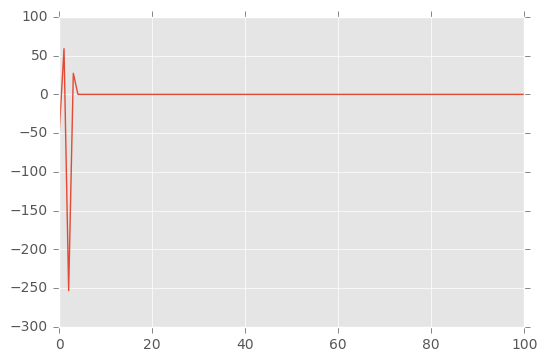

In [318]:
plt.plot(deltam)

In [319]:
hinit

array([   30., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
       -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
       -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
       -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
       -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
       -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
       -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
       -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
       -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
       -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
       -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
       -1000., -1000., -1000., -1000., -1000., -1000., -1000., -1000.,
       -1000., -1000., -1000., -1000., -1000.])

In [320]:
fmtstr = 'dt={0}, tol={1}'.format(dt, stop_tol)
printstr = 'dt={0}_tol={1}'.format(dt, stop_tol)

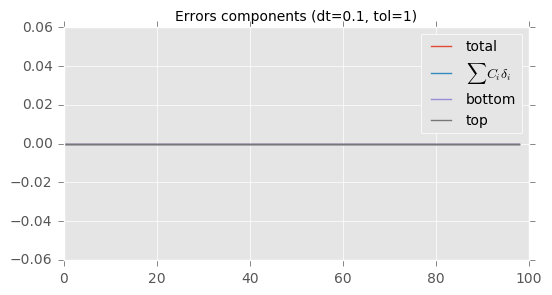

In [321]:
#  plot mass balance terms
fig=  plt.figure(1, figsize = (6,3))
plt.title('Errors components ({0})'.format(fmtstr), fontsize = 10)
# plt.plot(error[1:],   label = 'error' )
plt.plot(err_sum[1:], label = 'total')
plt.plot(err_c[1:], label = '$\sum C_i \delta_i$')
plt.plot(err_bot[1:], label = 'bottom')
plt.plot(err_top[1:], label = 'top')
plt.legend(loc = 'best', fontsize = 10)
fig.savefig('plots/error components {0}.pdf'.format(printstr))

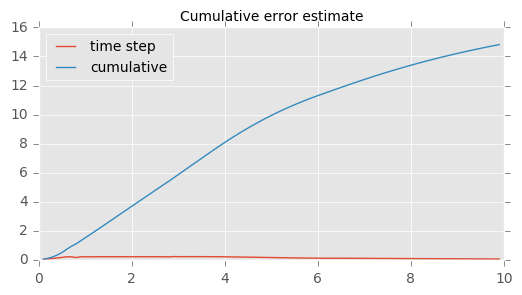

In [322]:
#  cumulative error
fig=  plt.figure(1, figsize = (6,3))
plt.title('Cumulative error estimate'.format(fmtstr), fontsize = 10)
plt.plot(t[1:], fluxin[1:] - newmass + fluxout[1:] - error[1:] ,  label = 'time step')
plt.plot(t[1:], np.cumsum(fluxin[1:] - newmass + fluxout[1:] - error[1:] ), label =  'cumulative')
# plt.plot(t[1:], np.cumsum(fluxin[1:] - newmass + fluxout[1:]  ), '--', label =  'unclosed')
plt.legend(loc = 'best', fontsize = 10)
fig.savefig('plots/cumulative error {0}.pdf'.format(printstr))

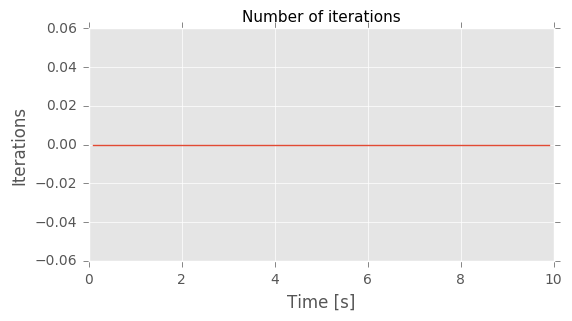

In [323]:
plt.figure(1, figsize = (6,3))
plt.plot(t[1:nt],iterations,'-')
plt.xlabel('Time [s]')
plt.title('Number of iterations', fontsize = 11)
plt.ylabel('Iterations')
fig.savefig('plots/iterations {0}.pdf'.format(printstr))

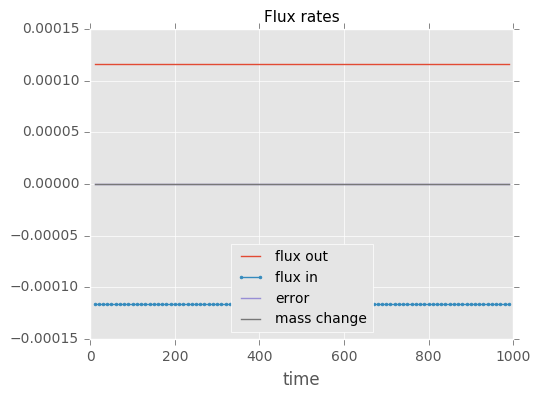

In [290]:
#  plot mass balance terms
plt.figure(1, figsize = (12,4))
ax = plt.subplot(121)
plt.title('Flux rates', fontsize = 11)
plt.plot(t[1:], fluxout[1:]/dt, label = 'flux out')
plt.plot(t[1:], fluxin[1:]/dt, '.-', ms = 4, label = 'flux in')
plt.plot(t[1:], error[1:]/dt, label = 'error')
plt.plot(t[1:], newmass/dt, label = 'mass change')
plt.legend(loc = 'best', fontsize = 10)
plt.xlabel('time')
fig.savefig('plots/flux rates {0}.pdf'.format(printstr))

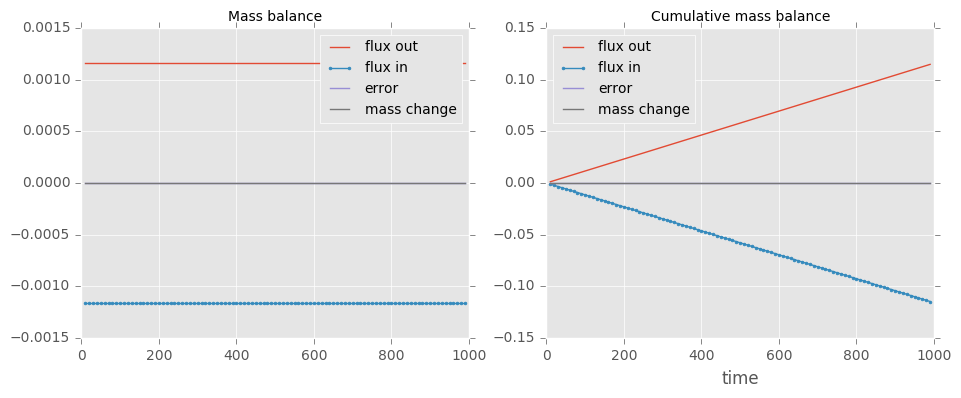

In [291]:
#  plot mass balance terms
plt.figure(1, figsize = (11,4))
ax = plt.subplot(121)
plt.title('Mass balance', fontsize = 10)
plt.plot(t[1:], fluxout[1:], label = 'flux out')
plt.plot(t[1:], fluxin[1:], '.-', ms = 4, label = 'flux in')
plt.plot(t[1:], error[1:], label = 'error')
plt.plot(t[1:], newmass, label = 'mass change')
plt.legend(loc = 'best', fontsize = 10)
ax = plt.subplot(122)
plt.title('Cumulative mass balance', fontsize = 10)
plt.plot(t[1:], np.cumsum(fluxout[1:]), label = 'flux out')
plt.plot(t[1:], np.cumsum(fluxin[1:]), '.-', ms = 4, label = 'flux in')
plt.plot(t[1:], np.cumsum(error[1:]), label = 'error')
plt.plot(t[1:], np.cumsum(newmass), label = 'mass change')
plt.legend(loc = 'best', fontsize = 10)
plt.xlabel('time')
fig.savefig('plots/mass balance {0}.pdf'.format(printstr))

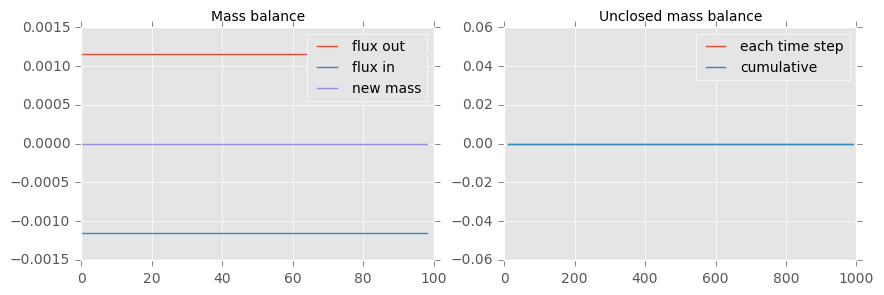

In [292]:
#  Unclosed mass balance
plt.figure(1, figsize = (10,3))
ax = plt.subplot(121)
plt.title('Mass balance', fontsize = 10)
plt.plot(fluxout[1:], label = 'flux out')
plt.plot(fluxin[1:], label = 'flux in')
plt.plot(newmass, label = 'new mass')
plt.legend(fontsize = 10)
ax = plt.subplot(122)
plt.title('Unclosed mass balance', fontsize = 10)
plt.plot(t[1:], fluxin[1:] - newmass + fluxout[1:],  label = 'each time step')
plt.plot(t[1:], np.cumsum(fluxin[1:] - newmass+ fluxout[1:]), label =  'cumulative')
plt.legend(fontsize = 10)